In [82]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
import gc
import harmonypy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import copy

# Anndata creation

In [83]:
adata = sc.read_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/FluYr1D0_certpro.h5ad')

In [84]:
adata.X[10:50,10:50].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [85]:
adata

AnnData object with n_obs × n_vars = 1539411 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'

In [86]:
adata.layers["counts"] = adata.X.copy()

In [87]:
adata

AnnData object with n_obs × n_vars = 1539411 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'
    layers: 'counts'

In [88]:
# adata.write_h5ad('/home/jupyter/Myeloid_cells/files/FluYr1D0_with_counts_layer.h5ad')

In [89]:
adata.obs['cohort.cohortGuid'].unique()

['BR1', 'BR2']
Categories (2, object): ['BR1', 'BR2']

In [90]:
# Define the cell types you want to subset
selected_cell_types = ['IL1B+ CD14 monocyte']
#selected_cell_types = ['IL1B+ CD14 monocyte']

subset_adata = adata[adata.obs['AIFI_L3'].isin(selected_cell_types), :]
subset_adata.obs['AIFI_L3'].value_counts()

AIFI_L3
IL1B+ CD14 monocyte    2835
Name: count, dtype: int64

In [91]:
subset_adata

View of AnnData object with n_obs × n_vars = 2835 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'
    layers: 'counts'

In [92]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/IL1B_CD14_Mono_ONLY_FluYr1D0_certpro_raw_051524.h5ad')

In [93]:
subset_adata.raw= subset_adata

In [94]:
subset_adata.obs

,barcodes,original_barcodes,cell_name,batch_id,pool_id,chip_id,well_id,n_genes,n_reads,n_umis,...,subject.bmi,subject.race,subject.ethnicity,subject.birthYear,subject.ageAtFirstDraw,sample.visitName,sample.drawDate,sample.subjectAgeAtDraw,specimen.specimenGuid,pipeline.fileGuid
barcodes,,,,,,,,,,,,,,,,,,,,,
70ab258848b611eaa65d9e7d578d66f2,70ab258848b611eaa65d9e7d578d66f2,ATCACTTAGATACAGT,pine_enervated_caracal,B001,B001-P1,B001-P1C1,B001-P1C1W2,2354,27740,8105,...,23.0,Caucasian,Non-Hispanic origin,1987,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec
70acf29648b611eaa65d9e7d578d66f2,70acf29648b611eaa65d9e7d578d66f2,ATGCCTCGTTTGAACC,bland_sandy_owl,B001,B001-P1,B001-P1C1,B001-P1C1W2,4302,73872,21505,...,23.0,Caucasian,Non-Hispanic origin,1987,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec
70d2b34648b611eaa65d9e7d578d66f2,70d2b34648b611eaa65d9e7d578d66f2,TCAGTTTAGCGCCTCA,mellow_intact_gecko,B001,B001-P1,B001-P1C1,B001-P1C1W2,2176,20037,6038,...,23.0,Caucasian,Non-Hispanic origin,1987,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec
a711a6d8489811ea92388a6a0c683ffb,a711a6d8489811ea92388a6a0c683ffb,AGACCATAGCGTCAAG,villainous_preoceanic_jackal,B001,B001-P1,B001-P1C1,B001-P1C1W3,1287,9010,2906,...,23.0,Caucasian,Non-Hispanic origin,1987,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec
a78438c4489811ea92388a6a0c683ffb,a78438c4489811ea92388a6a0c683ffb,TTCCACGTCTTTCCGG,abdicable_centerable_gnu,B001,B001-P1,B001-P1C1,B001-P1C1W3,1051,6492,2278,...,23.0,Caucasian,Non-Hispanic origin,1987,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ce432b48286411eca744faae388e9f17,ce432b48286411eca744faae388e9f17,TAGGTACCATGTAACC,sly_fleshy_kitty,B085,B085-P2,B085-P2C3,B085-P2C3W3,2974,38175,10723,...,29.0,Caucasian,Non-Hispanic origin,1992,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb
ce49cb56286411eca744faae388e9f17,ce49cb56286411eca744faae388e9f17,TGTAGACAGTCAACAA,cavitied_amebic_wildcat,B085,B085-P2,B085-P2C3,B085-P2C3W3,3483,46544,13942,...,29.0,Caucasian,Non-Hispanic origin,1992,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb
fbe4aa18286411ecb1698ec288c6fba6,fbe4aa18286411ecb1698ec288c6fba6,ATTCACTCAGGTATGG,topnotch_antelopine_chipmunk,B085,B085-P2,B085-P2C3,B085-P2C3W4,1595,11363,4077,...,29.0,Caucasian,Non-Hispanic origin,1992,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb


In [95]:
%%time
sc.pp.normalize_total(subset_adata, target_sum=1e4)
sc.pp.log1p(subset_adata)

CPU times: user 74.7 ms, sys: 276 ms, total: 350 ms
Wall time: 352 ms


In [96]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/IL1B_CD14_Mono_ONLY_FluYr1D0_certpro_normalized_unscaled_05152024.h5ad')

In [97]:
%%time

sc.pp.highly_variable_genes(subset_adata)
subset_adata = subset_adata[:, subset_adata.var_names[subset_adata.var['highly_variable']]]

CPU times: user 731 ms, sys: 2.63 s, total: 3.37 s
Wall time: 3.41 s


In [98]:
sc.pp.scale(subset_adata)

In [99]:
sc.tl.pca(subset_adata, svd_solver='arpack')

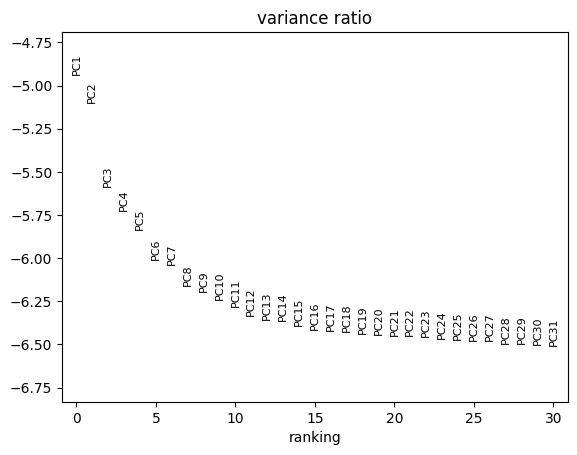

In [100]:
sc.pl.pca_variance_ratio(subset_adata, log=True)

In [101]:
%%time

sce.pp.harmony_integrate(subset_adata, 'cohort.cohortGuid',max_iter_harmony = 30)

2024-05-15 20:10:19,016 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-05-15 20:10:22,200 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-05-15 20:10:22,224 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2024-05-15 20:10:22,976 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2024-05-15 20:10:23,696 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2024-05-15 20:10:24,453 - harmonypy - INFO - Iteration 4 of 30
Iteration 4 of 30
2024-05-15 20:10:25,187 - harmonypy - INFO - Iteration 5 of 30
Iteration 5 of 30
2024-05-15 20:10:25,862 - harmonypy - INFO - Iteration 6 of 30
Iteration 6 of 30
2024-05-15 20:10:26,501 - harmonypy - INFO - Iteration 7 of 30
Iteration 7 of 30
2024-05-15 20:10:26,933 - harmonypy - INFO - Iteration 8 of 30
Iteration 8 of 30
2024-05-15 20:10:27,335 - harmonypy - INFO - Iteration 9 of 30
Iteration 9 of 30

CPU times: user 4min 2s, sys: 5min 20s, total: 9min 23s
Wall time: 9.11 s


In [102]:
%%time

sc.pp.neighbors(subset_adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(subset_adata)

CPU times: user 16.9 s, sys: 13.8 s, total: 30.6 s
Wall time: 9.79 s


In [103]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/IL1B_CD14_Mono_ONLY_FluYr1D0_certpro_post_harmony_05152024.h5ad')

In [104]:
def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata

In [105]:
%%time


tasks = [(0.5, "leiden_resolution_0.5"),(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
subset_adata = run_leiden_parallel(subset_adata, tasks)

CPU times: user 410 ms, sys: 10.5 s, total: 10.9 s
Wall time: 19 s


In [106]:
subset_adata.write_h5ad('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/IL1B_CD14_Mono_ONLY_FluYr1D0_certpro_processed_05152024.h5ad')

In [107]:
#subset_adata.write_h5ad('/home/jupyter/Myeloid_cells/files/IL1B_CD14_Mono_ONLY_FluYr1D0_parallel.h5ad')

In [108]:
subset_adata

AnnData object with n_obs × n_vars = 2835 × 2710
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
  

In [109]:
#adata = sc.read_h5ad('/home/jupyter/Myeloid_cells/files/IL1B_CD14_Mono_ONLY_FluYr1D0_parallel.h5ad')

In [110]:
obs = subset_adata.obs

In [111]:
obs

,barcodes,original_barcodes,cell_name,batch_id,pool_id,chip_id,well_id,n_genes,n_reads,n_umis,...,subject.ageAtFirstDraw,sample.visitName,sample.drawDate,sample.subjectAgeAtDraw,specimen.specimenGuid,pipeline.fileGuid,leiden_resolution_0.5,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2
barcodes,,,,,,,,,,,,,,,,,,,,,
70ab258848b611eaa65d9e7d578d66f2,70ab258848b611eaa65d9e7d578d66f2,ATCACTTAGATACAGT,pine_enervated_caracal,B001,B001-P1,B001-P1C1,B001-P1C1W2,2354,27740,8105,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,1,1,1,7
70acf29648b611eaa65d9e7d578d66f2,70acf29648b611eaa65d9e7d578d66f2,ATGCCTCGTTTGAACC,bland_sandy_owl,B001,B001-P1,B001-P1C1,B001-P1C1W2,4302,73872,21505,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,4,3,2
70d2b34648b611eaa65d9e7d578d66f2,70d2b34648b611eaa65d9e7d578d66f2,TCAGTTTAGCGCCTCA,mellow_intact_gecko,B001,B001-P1,B001-P1C1,B001-P1C1W2,2176,20037,6038,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,5,7,11
a711a6d8489811ea92388a6a0c683ffb,a711a6d8489811ea92388a6a0c683ffb,AGACCATAGCGTCAAG,villainous_preoceanic_jackal,B001,B001-P1,B001-P1C1,B001-P1C1W3,1287,9010,2906,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,2,3,12
a78438c4489811ea92388a6a0c683ffb,a78438c4489811ea92388a6a0c683ffb,TTCCACGTCTTTCCGG,abdicable_centerable_gnu,B001,B001-P1,B001-P1C1,B001-P1C1W3,1051,6492,2278,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,1,1,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ce432b48286411eca744faae388e9f17,ce432b48286411eca744faae388e9f17,TAGGTACCATGTAACC,sly_fleshy_kitty,B085,B085-P2,B085-P2C3,B085-P2C3W3,2974,38175,10723,...,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb,2,2,3,2
ce49cb56286411eca744faae388e9f17,ce49cb56286411eca744faae388e9f17,TGTAGACAGTCAACAA,cavitied_amebic_wildcat,B085,B085-P2,B085-P2C3,B085-P2C3W3,3483,46544,13942,...,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb,2,2,3,2
fbe4aa18286411ecb1698ec288c6fba6,fbe4aa18286411ecb1698ec288c6fba6,ATTCACTCAGGTATGG,topnotch_antelopine_chipmunk,B085,B085-P2,B085-P2C3,B085-P2C3W4,1595,11363,4077,...,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb,3,8,9,9


In [112]:
obs.to_csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/Il1B_Cd14_mono_obsdata_certpro.csv", index= False)

# Clustering analysis

In [113]:
adata = sc.read ('/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Object_generation/IL1B_CD14_Mono_ONLY_FluYr1D0_certpro_processed_05152024.h5ad')
adata

AnnData object with n_obs × n_vars = 2835 × 2710
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
  

In [114]:
obs = adata.obs

In [115]:
obs

,barcodes,original_barcodes,cell_name,batch_id,pool_id,chip_id,well_id,n_genes,n_reads,n_umis,...,subject.ageAtFirstDraw,sample.visitName,sample.drawDate,sample.subjectAgeAtDraw,specimen.specimenGuid,pipeline.fileGuid,leiden_resolution_0.5,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2
barcodes,,,,,,,,,,,,,,,,,,,,,
70ab258848b611eaa65d9e7d578d66f2,70ab258848b611eaa65d9e7d578d66f2,ATCACTTAGATACAGT,pine_enervated_caracal,B001,B001-P1,B001-P1C1,B001-P1C1W2,2354,27740,8105,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,1,1,1,7
70acf29648b611eaa65d9e7d578d66f2,70acf29648b611eaa65d9e7d578d66f2,ATGCCTCGTTTGAACC,bland_sandy_owl,B001,B001-P1,B001-P1C1,B001-P1C1W2,4302,73872,21505,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,4,3,2
70d2b34648b611eaa65d9e7d578d66f2,70d2b34648b611eaa65d9e7d578d66f2,TCAGTTTAGCGCCTCA,mellow_intact_gecko,B001,B001-P1,B001-P1C1,B001-P1C1W2,2176,20037,6038,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,5,7,11
a711a6d8489811ea92388a6a0c683ffb,a711a6d8489811ea92388a6a0c683ffb,AGACCATAGCGTCAAG,villainous_preoceanic_jackal,B001,B001-P1,B001-P1C1,B001-P1C1W3,1287,9010,2906,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,2,2,3,12
a78438c4489811ea92388a6a0c683ffb,a78438c4489811ea92388a6a0c683ffb,TTCCACGTCTTTCCGG,abdicable_centerable_gnu,B001,B001-P1,B001-P1C1,B001-P1C1W3,1051,6492,2278,...,32,Flu Year 1 Day 0,2019-10,32,PB00001-01,fec489f9-9a74-4635-aa91-d2bf09d1faec,1,1,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ce432b48286411eca744faae388e9f17,ce432b48286411eca744faae388e9f17,TAGGTACCATGTAACC,sly_fleshy_kitty,B085,B085-P2,B085-P2C3,B085-P2C3W3,2974,38175,10723,...,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb,2,2,3,2
ce49cb56286411eca744faae388e9f17,ce49cb56286411eca744faae388e9f17,TGTAGACAGTCAACAA,cavitied_amebic_wildcat,B085,B085-P2,B085-P2C3,B085-P2C3W3,3483,46544,13942,...,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb,2,2,3,2
fbe4aa18286411ecb1698ec288c6fba6,fbe4aa18286411ecb1698ec288c6fba6,ATTCACTCAGGTATGG,topnotch_antelopine_chipmunk,B085,B085-P2,B085-P2C3,B085-P2C3W4,1595,11363,4077,...,29,Flu Year 1 Day 0,2021-01,29,PB01446-01,f25a148f-3330-4870-8550-9d09933871fb,3,8,9,9


In [116]:
#obs.to_csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Frequency_Plot/Il1B_Cd14_mono_obsdata_v2.csv", index= False)

In [117]:
adata.X

array([[-0.13641515, -0.1176541 , -0.1794149 , ...,  3.4227571 ,
        -0.23650548, -0.15485258],
       [-0.13641515, -0.1176541 , -0.1794149 , ..., -0.22456671,
        -0.23650548, -0.15485258],
       [-0.13641515, -0.1176541 , -0.1794149 , ..., -0.22456671,
        -0.23650548, -0.15485258],
       ...,
       [-0.13641515, -0.1176541 , -0.1794149 , ..., -0.22456671,
        -0.23650548, -0.15485258],
       [-0.13641515, -0.1176541 , -0.1794149 , ..., -0.22456671,
        -0.23650548, -0.15485258],
       [-0.13641515, -0.1176541 , -0.1794149 , ..., -0.22456671,
        -0.23650548, -0.15485258]], dtype=float32)

In [118]:
adata

AnnData object with n_obs × n_vars = 2835 × 2710
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
  

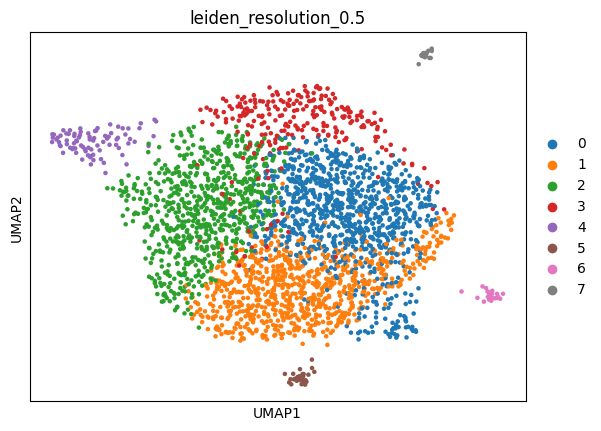

In [119]:
sc.pl.umap(adata, color=['leiden_resolution_0.5'])

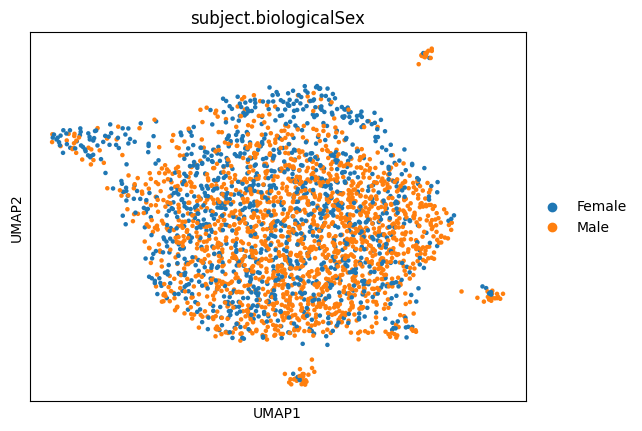

In [120]:
sc.pl.umap(adata, color=['subject.biologicalSex'])

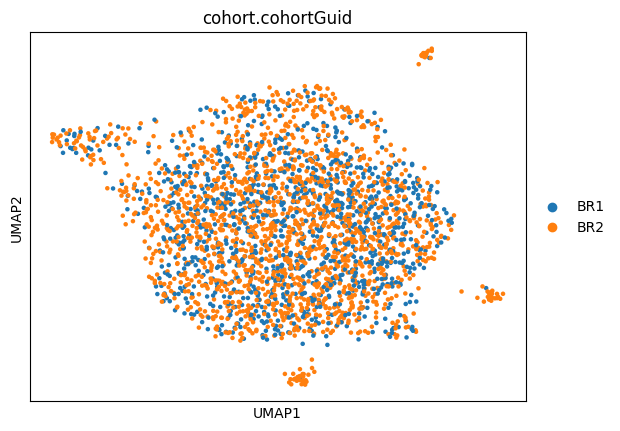

In [121]:
sc.pl.umap(adata, color=['cohort.cohortGuid'])

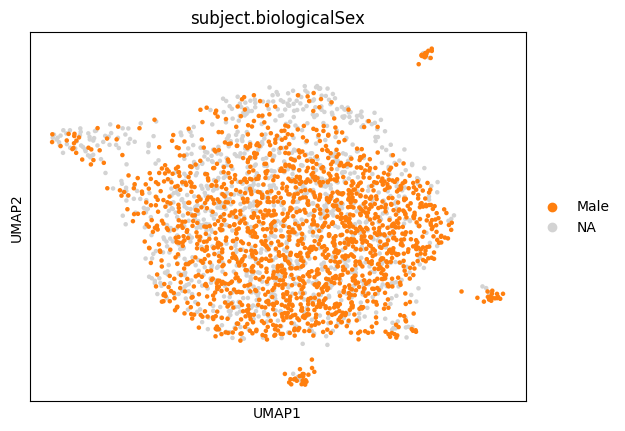

In [122]:
sc.pl.umap(adata, color = "subject.biologicalSex", groups = "Male")

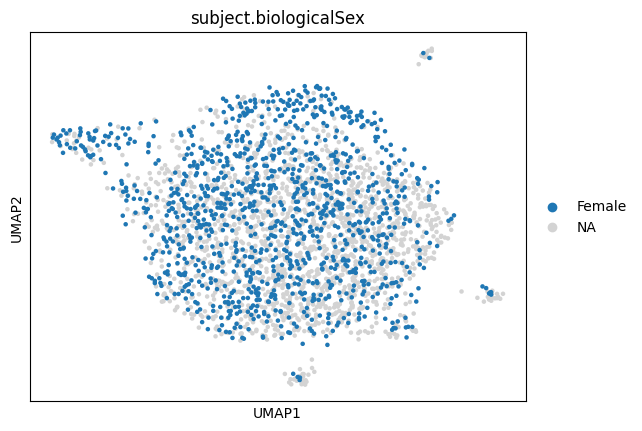

In [123]:
sc.pl.umap(adata, color = "subject.biologicalSex", groups = "Female")

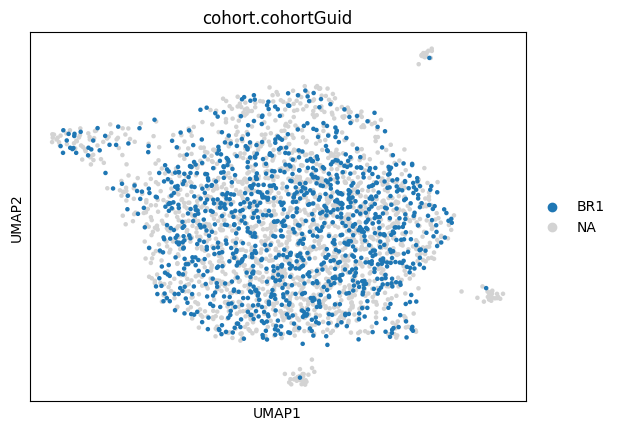

In [124]:
sc.pl.umap(adata, color = "cohort.cohortGuid", groups = "BR1")

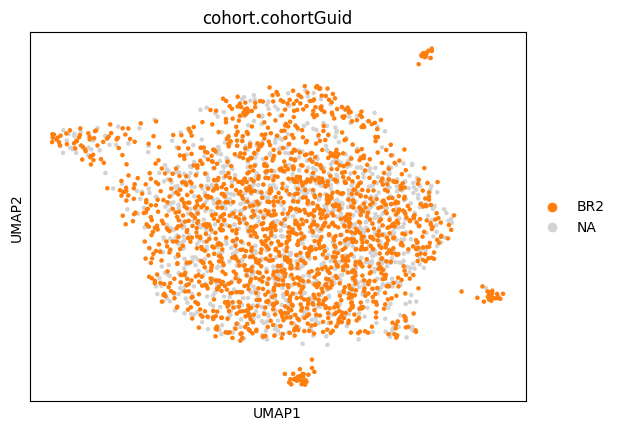

In [125]:
sc.pl.umap(adata, color = "cohort.cohortGuid", groups = "BR2")

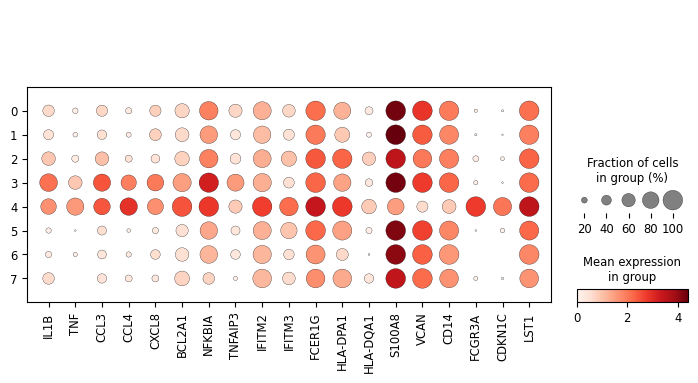

In [126]:
sc.pl.dotplot(adata, ['IL1B', 'TNF', 'CCL3', 'CCL4', 'CXCL8', 'BCL2A1', 'NFKBIA', 'TNFAIP3', 'IFITM2', 'IFITM3', 'FCER1G', 'HLA-DPA1', 'HLA-DQA1', 
'S100A8', 'VCAN', 'CD14',  'FCGR3A', 'CDKN1C', 'LST1'], "leiden_resolution_0.5",
              #save=  proj_name+'_rna_TNF_dotpolt.png',
              dendrogram=False, log= True)

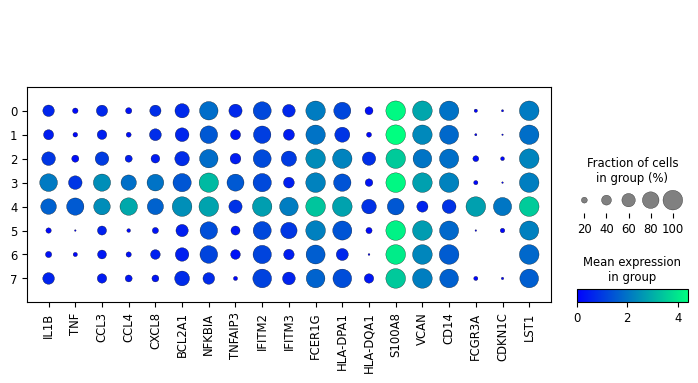

In [127]:
sc.pl.DotPlot(adata, ['IL1B', 'TNF', 'CCL3', 'CCL4', 'CXCL8', 'BCL2A1', 'NFKBIA', 'TNFAIP3', 'IFITM2', 'IFITM3', 'FCER1G', 'HLA-DPA1', 'HLA-DQA1', 
'S100A8', 'VCAN', 'CD14',  'FCGR3A', 'CDKN1C', 'LST1'], "leiden_resolution_0.5",
              #save=  proj_name+'_rna_TNF_dotpolt.png',
               log= True).show()

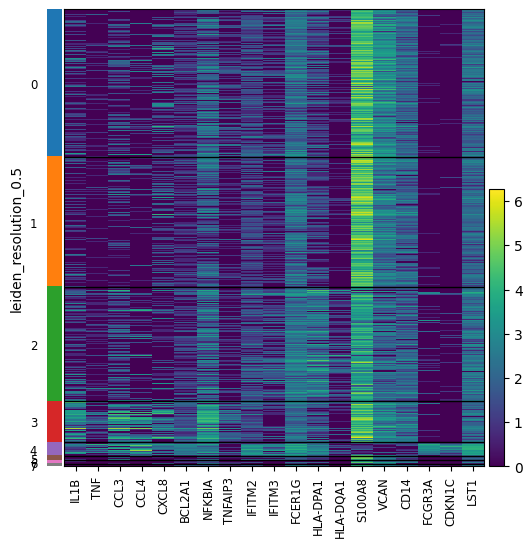

In [128]:
markers = ['IL1B', 'TNF', 'CCL3', 'CCL4', 'CXCL8', 'BCL2A1', 'NFKBIA', 'TNFAIP3', 'IFITM2', 'IFITM3', 'FCER1G', 'HLA-DPA1', 'HLA-DQA1', 
'S100A8', 'VCAN', 'CD14',  'FCGR3A', 'CDKN1C', 'LST1']
sc.pl.heatmap(adata, markers, groupby='leiden_resolution_0.5', swap_axes=False, log= True)

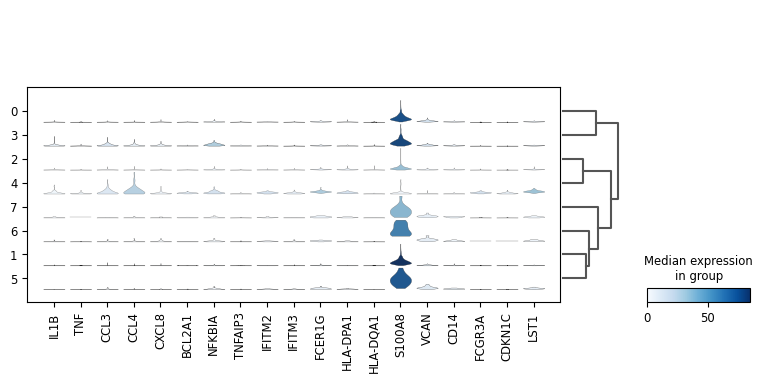

In [129]:
markers = ['IL1B', 'TNF', 'CCL3', 'CCL4', 'CXCL8', 'BCL2A1', 'NFKBIA', 'TNFAIP3', 'IFITM2', 'IFITM3', 'FCER1G', 'HLA-DPA1', 'HLA-DQA1', 
'S100A8', 'VCAN', 'CD14',  'FCGR3A', 'CDKN1C', 'LST1']
sc.pl.stacked_violin(adata, markers, groupby='leiden_resolution_0.5', dendrogram=True)

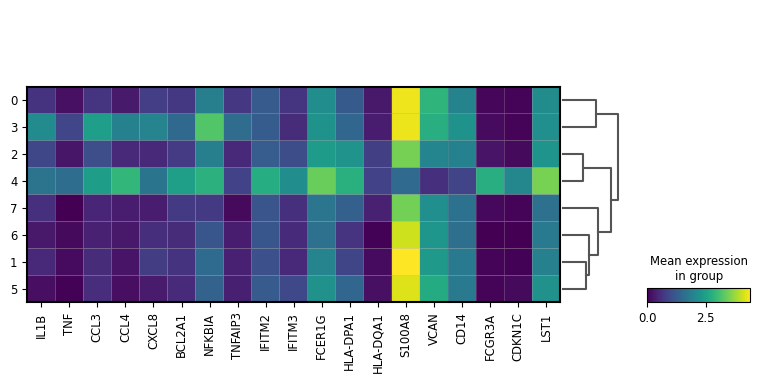

In [130]:
markers = ['IL1B', 'TNF', 'CCL3', 'CCL4', 'CXCL8', 'BCL2A1', 'NFKBIA', 'TNFAIP3', 'IFITM2', 'IFITM3', 'FCER1G', 'HLA-DPA1', 'HLA-DQA1', 
'S100A8', 'VCAN', 'CD14',  'FCGR3A', 'CDKN1C', 'LST1']
sc.pl.matrixplot(adata, markers, groupby='leiden_resolution_0.5', dendrogram=True, log = True)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

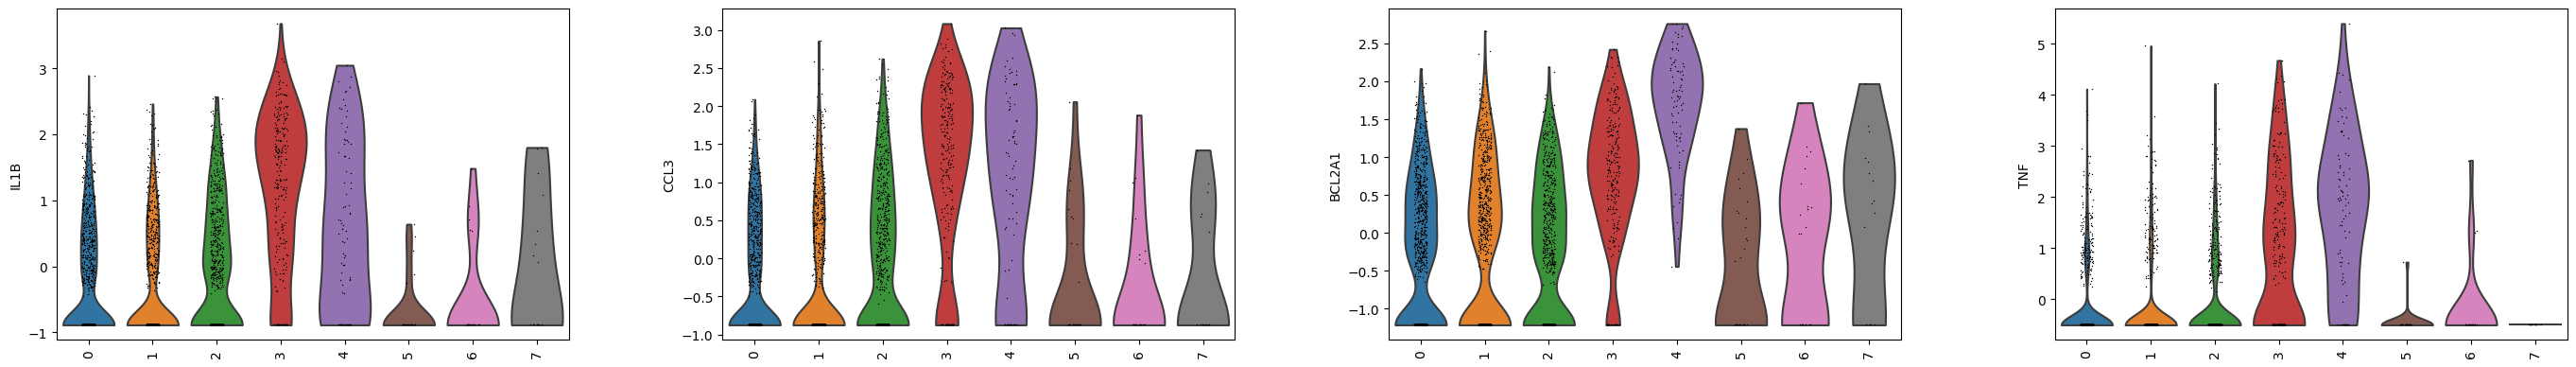

In [131]:
sc.pl.violin(adata, ['IL1B', 'CCL3', 'BCL2A1', 'TNF'], groupby='leiden_resolution_0.5', rotation=90, use_raw= False)


In [132]:
# # Assuming 'adata' is your AnnData object

# # Create a new column by combining two existing columns
# adata.obs['facet'] = adata.obs['subject.biologicalSex'] + '_' + adata.obs['cohort.cohortGuid'] 

# # Assuming 'adata' is your AnnData object

# # Convert categorical column to string
# adata.obs['subject.biologicalSex'] = adata.obs['subject.biologicalSex'].astype(str)

# Create a new column by combining two existing columns
adata.obs['new_column'] = adata.obs['subject.biologicalSex'].astype(str) + '_' + adata.obs['cohort.cohortGuid'].astype(str)

adata.obs['new_column'].unique

<bound method Series.unique of barcodes
70ab258848b611eaa65d9e7d578d66f2    Female_BR1
70acf29648b611eaa65d9e7d578d66f2    Female_BR1
70d2b34648b611eaa65d9e7d578d66f2    Female_BR1
a711a6d8489811ea92388a6a0c683ffb    Female_BR1
a78438c4489811ea92388a6a0c683ffb    Female_BR1
                                       ...    
ce432b48286411eca744faae388e9f17      Male_BR1
ce49cb56286411eca744faae388e9f17      Male_BR1
fbe4aa18286411ecb1698ec288c6fba6      Male_BR1
03c5255a286511ec8289ca5980196c9c      Male_BR1
91f8844a286311ecabc39e0459bddc54      Male_BR1
Name: new_column, Length: 2835, dtype: object>

In [133]:
# import scanpy as sc
# import matplotlib.pyplot as plt

# # Assuming 'adata' is your AnnData object

# # # Run UMAP
# # sc.pp.neighbors(adata)
# # sc.tl.umap(adata)

# # Plot UMAP with color and shape based on metadata columns
# sc.pl.umap(adata, color='metadata_column1', palette='viridis', use_raw=False, legend_loc='on data', legend_fontsize=12)
# sc.pl.umap(adata, color='metadata_column2', palette='viridis', use_raw=False, legend_loc='on data', legend_fontsize=12, add_outline=True, outline_width=0.5)
# plt.show()


... storing 'new_column' as categorical


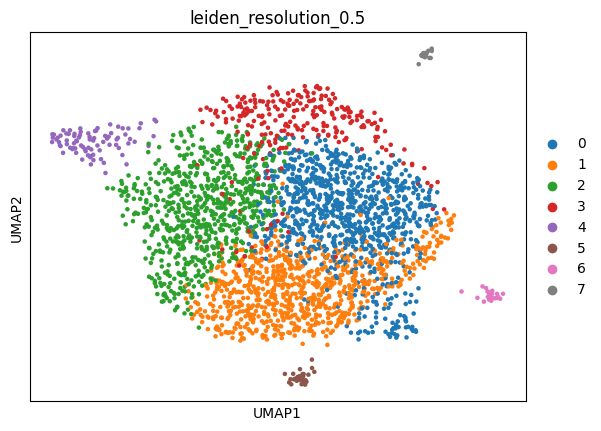

In [134]:
sc.pl.umap(adata, color=['leiden_resolution_0.5'])

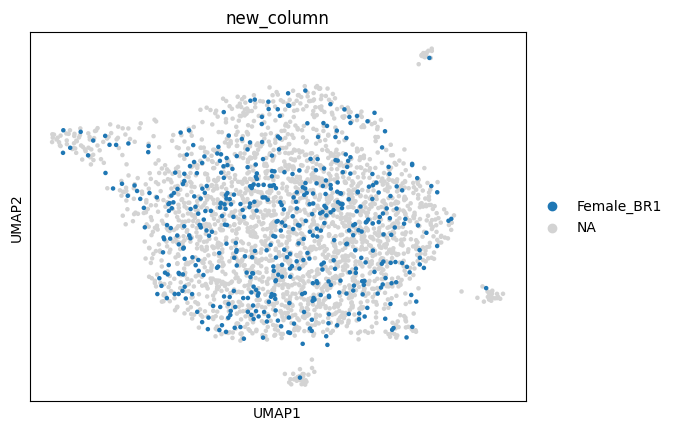

In [135]:
sc.pl.umap(adata, color = "new_column", groups = "Female_BR1")

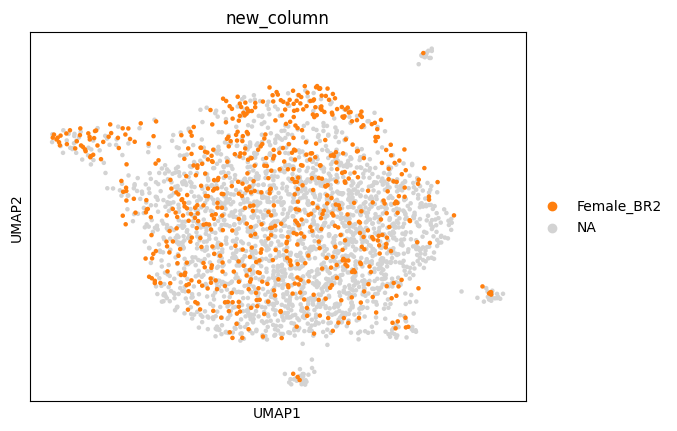

In [136]:
sc.pl.umap(adata, color = "new_column", groups = "Female_BR2")

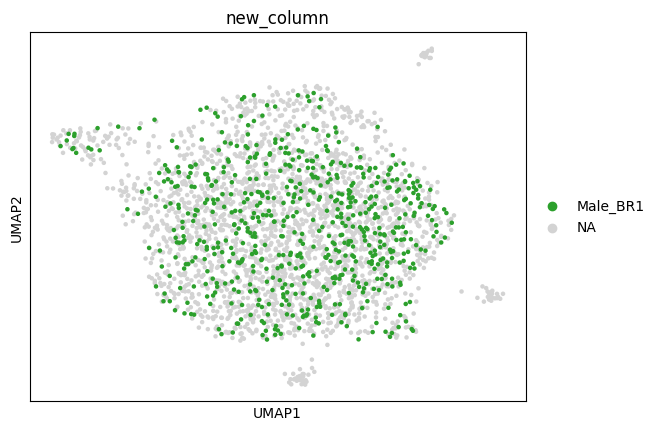

In [137]:
sc.pl.umap(adata, color = "new_column", groups = "Male_BR1")

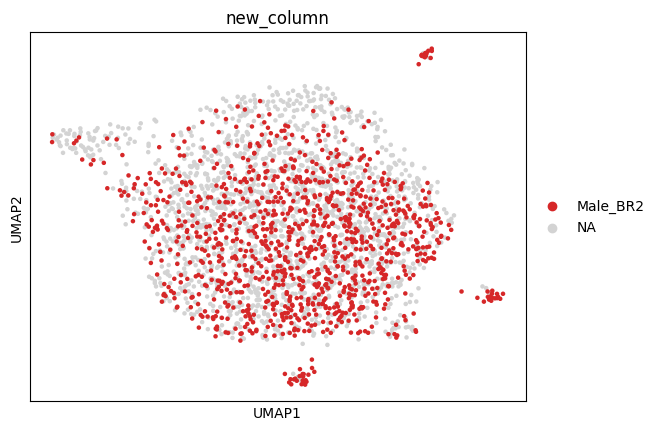

In [138]:
sc.pl.umap(adata, color = "new_column", groups = "Male_BR2")

In [144]:
adata

AnnData object with n_obs × n_vars = 2835 × 2710
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'leiden_resolution_0.5', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2', 'new_column'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'leiden_resolution_0.5_colors', 'subject.biologi

In [145]:
adata.obs['subject.biologicalSex'].value_counts()

subject.biologicalSex
Male      1704
Female    1131
Name: count, dtype: int64

In [146]:
adata.obs['cohort.cohortGuid'].value_counts()

cohort.cohortGuid
BR2    1732
BR1    1103
Name: count, dtype: int64

In [147]:
adata.obs['new_column'].value_counts()

new_column
Male_BR2      1077
Female_BR2     655
Male_BR1       627
Female_BR1     476
Name: count, dtype: int64

In [148]:
# Group the data by cluster labels and aggregate the donors
donors_per_cluster = adata.obs.groupby('new_column')['subject.subjectGuid'].nunique()

# Print the list of donors per cluster
print(donors_per_cluster)

new_column
Female_BR1    26
Female_BR2    25
Male_BR1      21
Male_BR2      20
Name: subject.subjectGuid, dtype: int64
